# HW2
### 根據UCI-Sonar資料集(2 classes, 60 features) 
1. 計算Bhattacharyya distance
2. 計算Bhattacharyya and Chernoff error bound
3. 和HW1的結果做討論

## 基本概念

### Bayesian Classifier

統計學指出："若資料的分布狀態為常態分佈時，貝氏分類器必為最佳的分類器。"

代號：
* $ Q_{i}(x) = P(w_{i}|x)$ ----------------- posterior 在特徵$x$的情況下為類別$w_{i}$的機率
* $ P_{i}(x) = P(x|w_{i})$ ----------------- likelihood 在類別$w_{i}$的情況下特徵$x$發生的機率
* $ P_{i} = P(w_{i})$ --------------------------- pior 不考慮任何特徵影響，類別$w_{i}$發生的機率

$$ posterior = \frac{likelihood \times pior}{evidence} => Q_{i}(x) = \frac{P_{i}(x) P_{i}}{P(x)} $$

Decision Rule：
Decide $w_{1}$ if $Q_{1}(x) > Q_{2}(x)$; Otherwise decide $w_{2}$.

白話-計算出來的後驗機率誰大就判給誰。

### Upper Bounds on the Bayes Error

在只分兩個類別的情況下，我們將物件判為後驗機率最大的類別，因此錯誤率就會是：
$$P(error) = \int min[P_1P_1(X), P_2P_2(X)]dX$$

在最理想的情況下，錯誤率是closed-form express，但是當我們無法得到closed-form express時，通常會使用兩種方式處理：
1. 找出錯誤率的approximate express
2. 找出錯誤率的upper bound

#### Chernoff Bound

任意兩正數之幾何平均數必大於兩數之間較小的數。
$$min[a, b]  \leq a^sb^{1-s}, 0\leq s\leq 1$$
因此，$$P(error) = \int min[P_1P_1(X), P_2P_2(X)]dX$$
$$P(error) \leq P^s_1P^{1-s}_2\int P^s(X)P^{1-s}(X)dX$$
在常態分佈中，$$\int P_1^s(X)P_2^{1-s}(X)dX = e^{-\mu (s)}$$
$$\mu(s) = \frac{s(1-s)}{2}(M_2-M_1)^T[s\Sigma_1 + (1-s)\Sigma_2]^{-1}(M_2-M_1) + \frac{1}{2}ln\frac{|s\Sigma_1+ (1-s)\Sigma_2|}{|\Sigma_1|^s|\
\Sigma_2|^{1-s}}$$
$\mu(s)$就是Chernoff Distance，s的值會決定$\mu(s)$的最大值。

#### Bhattacharyya Bound

選擇$s = \frac{1}{2}$時，upper bound為
$$\sqrt[]{P_1P_2}\int \sqrt[]{P_1(X)P_2(X)}dX = \sqrt[]{P_1P_2}e^{-\mu(\frac{1}{2})}$$
而在常態分佈中，可得到
$$\mu(\frac{1}{2}) = \frac{1}{8}(M_2-M_1)^T\frac{[\Sigma_1 +\Sigma_2]^{-1}}{2}(M_2-M_1) + \frac{1}{2}ln\frac{|\frac{\Sigma_1 + \Sigma_2}{2}|}{\sqrt[]{|\Sigma_1||\
\Sigma_2|}}$$
$\mu(\frac{1}{2})$就是Bhattacharyya Distance，在$\Sigma_1 = \Sigma_2$時，Bhattacharyya Distance會是最佳的Chernoff Distance。

## 資料集說明

### Connectionist Bench (Sonar, Mines vs. Rocks) Data Set
 dataset: http://archive.ics.uci.edu/ml/datasets/connectionist+bench+(sonar,+mines+vs.+rocks)
 * Number of Instances: 208
 * Number of Attributes: 60
 
information:
 * sonar.mines: contains 111 patterns obtained by bouncing sonar signals off a metal cylinder at various angles and under various conditions.
 * sonar.rocks: contains 97 patterns obtained from rocks under similar conditions.
 * The label associated with each record contains the letter "R" if the object is a rock and "M" if it is a mine (metal cylinder). The numbers in the labels are in increasing order of aspect angle, but they do not encode the angle directly.

## 基本想法

目的：將資料集的聲納分成兩類(Mines&Rocks)

step1. 將資料分成兩堆(50% for training, 50% for testing)。


step2. 使用50%的training data分別計算出兩個類別60個特徵的 $\mu$ (mean vector)，計算 $\Sigma$ (covariance matrices)。

step3. 利用mean vector和covariance matrices算出Bhattacharyya distance，進而計算Bhattacharyya and Chernoff error bound。


## 實作

### 連接Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!ls '/content/drive/My Drive/Pattern_Recognition/HW2'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
HW2.ipynb  sonar.all-data


### 讀取資料

In [0]:
file = '/content/drive/My Drive/Pattern_Recognition/HW2/sonar.all-data'
data = []
pr_m = 0  #prior of class M
pr_r = 0  ##prior of class R
with open(file,'r') as f:
  for line in f:
    dicts = {}
    features = line.strip('\n').split(',')
    dicts['class'] = features[len(features)-1]
    features = [float(features[i]) for i in range(len(features)-1)]
    dicts['feature'] = features
    data.append(dicts)
    if dicts['class'] == 'M':
      pr_m += 1
    elif dicts['class'] == 'R':
      pr_r += 1
    
pr_m = pr_m/len(data)
pr_r = pr_r/len(data)

print('data[0]:', data[0])
print('class of data[0]:', data[0]['class'])
print('feature of data[0]:', data[0]['feature'])
print('total:', len(data))
print('prior of m:', pr_m)
print('prior of r:', pr_r)


data[0]: {'class': 'R', 'feature': [0.02, 0.0371, 0.0428, 0.0207, 0.0954, 0.0986, 0.1539, 0.1601, 0.3109, 0.2111, 0.1609, 0.1582, 0.2238, 0.0645, 0.066, 0.2273, 0.31, 0.2999, 0.5078, 0.4797, 0.5783, 0.5071, 0.4328, 0.555, 0.6711, 0.6415, 0.7104, 0.808, 0.6791, 0.3857, 0.1307, 0.2604, 0.5121, 0.7547, 0.8537, 0.8507, 0.6692, 0.6097, 0.4943, 0.2744, 0.051, 0.2834, 0.2825, 0.4256, 0.2641, 0.1386, 0.1051, 0.1343, 0.0383, 0.0324, 0.0232, 0.0027, 0.0065, 0.0159, 0.0072, 0.0167, 0.018, 0.0084, 0.009, 0.0032]}
class of data[0]: R
feature of data[0]: [0.02, 0.0371, 0.0428, 0.0207, 0.0954, 0.0986, 0.1539, 0.1601, 0.3109, 0.2111, 0.1609, 0.1582, 0.2238, 0.0645, 0.066, 0.2273, 0.31, 0.2999, 0.5078, 0.4797, 0.5783, 0.5071, 0.4328, 0.555, 0.6711, 0.6415, 0.7104, 0.808, 0.6791, 0.3857, 0.1307, 0.2604, 0.5121, 0.7547, 0.8537, 0.8507, 0.6692, 0.6097, 0.4943, 0.2744, 0.051, 0.2834, 0.2825, 0.4256, 0.2641, 0.1386, 0.1051, 0.1343, 0.0383, 0.0324, 0.0232, 0.0027, 0.0065, 0.0159, 0.0072, 0.0167, 0.018, 0.008

### 正規化

In [0]:
from sklearn import preprocessing
import numpy as np

#normalize
tmp = np.array([i['feature'] for i in data])
tmp = preprocessing.scale(tmp)
for i in range(len(tmp)):
  data[i]['feature'] = tmp[i]

### 在資料集中選擇50%資料作為training data, 50%為test data
* 隨機分組
* 平均分組

擇一執行即可

In [0]:
# 隨機分配資料
import random

print('before shuffle:')
for i in data:
  print(i['class'], end=' ')
print()
random.shuffle(data)
print('after shuffle:')
for i in data:
  print(i['class'], end=' ')
print()
train_set = data[0: int(len(data)/2)]
test_set = data[int(len(data)/2): int(len(data))]
print('number of training set:', len(train_set))
for i in train_set:
  print(i['class'], end=' ')
print()
print('number of test set:', len(test_set))
for i in test_set:
  print(i['class'], end=' ')

before shuffle:
R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M 
after shuffle:
M R M M R M M R M R R M R M M R R R R M M M M R M M M M R R R R M R M M M M M M M M M M R M R M R R R R M M R R M M R R R R M R M R M M R R M M R R R M M M R R M M R R M R R R R R R R M M R R R R M R M R M R R M R R R M M M R M M R M R R M R M M M M M M M M M M R M R M M R R M R R M M R M R M R M R M M R M R M R R R M M M M R M M M M M M M M M M R R M M R M R M R R R R R M R M R R R M R M R R M M M R M R M R M M 
number of training set: 104
M R M M R M M R M R R M R M M R R R R M M M M R M M M M R R R R M R M M M M M M M M M M R M R M R R R R M M

In [0]:
# 平均分配資料
train_set = []
test_set = []
for i in range(len(data)):
  if i % 2 == 1:
    train_set.append(data[i])
  else:
    test_set.append(data[i])

print('number of train set:', len(train_set))    
for i in train_set:
  print(i['class'], end=' ')
print()
print('number of test set:', len(test_set))
for i in test_set:
  print(i['class'], end=' ')

number of train set: 104
R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M 
number of test set: 104
R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R R M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M 

### PCA

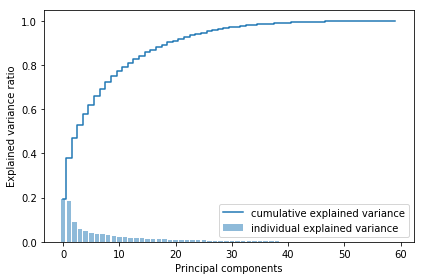

In [0]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

stdsc = StandardScaler()
# read data
all_feature_train = np.array([i['feature'] for i in train_set])
target_train = np.array([i['class'] for i in train_set])
all_feature_test = np.array([i['feature'] for i in test_set])
test_train = np.array([i['class'] for i in test_set])
# standard
all_feature_train = stdsc.fit_transform(all_feature_train)
all_feature_test = stdsc.fit_transform(all_feature_test)
# covariance matrix
cov_mat = np.cov(all_feature_train.T)
# eigenvector & eigenvalue
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
# count variance ratio
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
# print("各特徵值變異數比率：",var_exp)
# print("特徵值變異數比率累加：",cum_var_exp)
# draw graphs
plt.bar(range(0, len(all_feature_train[0])), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(0, len(all_feature_train[0])), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [0]:
# make a list of (eigenvalue, eigenvector) tunples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

In [0]:
eigen_pairs_index = []
for i in eigen_pairs:
  eigen_pairs_index.append(i[0])

In [0]:
# sort from high to law
eigen_pairs.sort(key = lambda k: k[0], reverse=True)

In [0]:
# reserved the best two eigenvalues
# matrix W is 60x2
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
# which feature we select
print(eigen_pairs_index.index(eigen_pairs[0][0]))
print(eigen_pairs_index.index(eigen_pairs[1][0]))

In [0]:
# reserved the best n eigenvalues
# matrix W is 60xn
n = 6
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print(eigen_pairs_index.index(eigen_pairs[0][0]))
print(eigen_pairs_index.index(eigen_pairs[1][0]))
for i in range(2, n):
  w = np.hstack((w, eigen_pairs[i][1][:, np.newaxis]))
  print(eigen_pairs_index.index(eigen_pairs[i][0]))


In [0]:
all_feature_train_pca = all_feature_train.dot(w)
all_feature_test_pca = all_feature_test.dot(w)

In [0]:
# draw graphs
colors = ['r', 'b']
markers = ['s', 'x']
for l, c, m in zip(np.unique(target_train), colors, markers):
    plt.scatter(all_feature_train_pca[target_train == l, 0], 
                all_feature_train_pca[target_train == l, 1], 
                c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [0]:
# 重組training set & testing set
for i in range(len(train_set)):
  train_set[i]['class'] = target_train[i]
  train_set[i]['feature'] = all_feature_train_pca[i]
for i in range(len(test_set)):
  test_set[i]['class'] = test_train[i]
  test_set[i]['feature'] = all_feature_test_pca[i]

### 分資料

In [0]:
import numpy as np
data_m = [i for i in train_set if i['class'] == 'M']
data_r = [i for i in train_set if i['class'] == 'R']
data_m_f = np.array([i['feature'] for i in data_m])
data_r_f = np.array([i['feature'] for i in data_r])
print('number of data_m:', len(data_m))
print('number of data_r:', len(data_r))

number of data_m: 56
number of data_r: 48


### 觀察特徵分佈

Feature  0


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


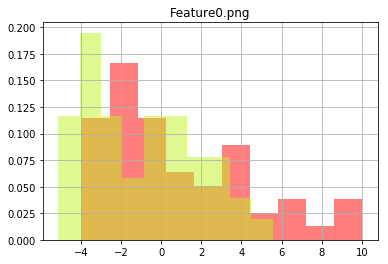

Feature  1


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


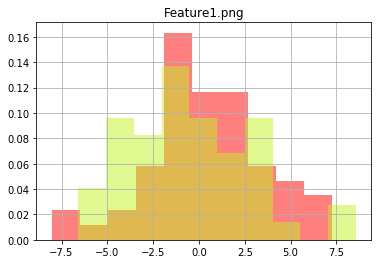

Feature  2


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


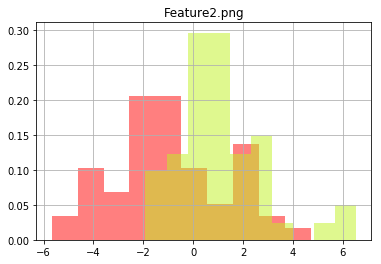

Feature  3


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


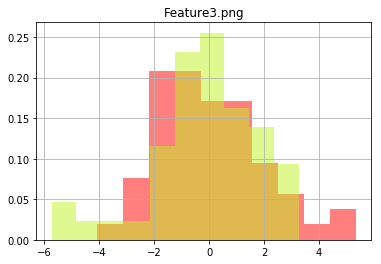

Feature  4


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


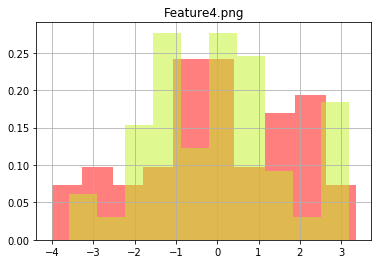

Feature  5


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


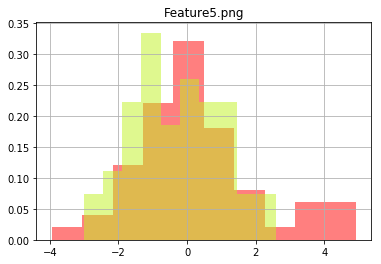

In [0]:
import scipy.stats as st
import matplotlib.pyplot as plt
from google.colab import files
# 觀察特徵分布
for i in range(len(data_m_f.T)):
  print('Feature ', i)
  # Mine
  probs = st.norm.pdf(data_m_f.T)
  plt.hist(data_m_f.T[i], normed=True, color="#FF0000", alpha=.5)
  # Rock
  probs = st.norm.pdf(data_r_f.T)
  plt.hist(data_r_f.T[i], normed=True, color="#C1F320", alpha=.5)
  plt.grid()
  filename = 'Feature' + str(i) + '.png'
  plt.title(filename)
  #plt.savefig(filename)
  #files.download(filename)
  plt.show()

### 特徵相關性

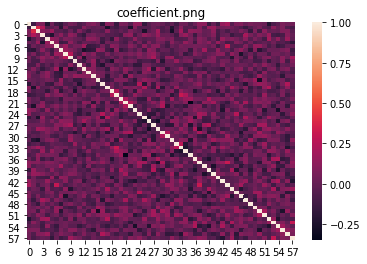

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(np.corrcoef(data_m_f.T))
filename = 'coefficient.png'
plt.title(filename)
plt.savefig(filename)
# files.download(filename)
plt.show()

### 分別計算mean vector & covariance matrices

In [0]:
import numpy as np

# calculate mean vector
def mean_vector(data):
  return np.mean(data,axis=0)

# calculate covariance matrix
def covariance_matrix(data):
  mean = np.mean(data,axis=0)
  data = data - mean
  cov_mat = data.T.dot(data) / (data.shape[0] - 1)
  return cov_mat

In [0]:
# mean vector
m_mu = mean_vector(data_m_f)
r_mu = mean_vector(data_r_f)
# covariance matrix
m_co = covariance_matrix(data_m_f)
r_co = covariance_matrix(data_r_f)
print('Mine')
print('mean vector:', m_mu)
print('Rock')
print('mean vector:', r_mu) 

Mine
mean vector: [ 0.88760649  0.43109941 -0.95424682  0.0512876   0.00832256  0.25605692]
Rock
mean vector: [-1.03554091 -0.50294931  1.11328796 -0.05983553 -0.00970966 -0.29873307]


### Chernoff distance
$$\mu(s) = \frac{s(1-s)}{2}(M_2-M_1)^T[s\Sigma_1 + (1-s)\Sigma_2]^{-1}(M_2-M_1) + \frac{1}{2}ln\frac{|s\Sigma_1+ (1-s)\Sigma_2|}{|\Sigma_1|^s|\
\Sigma_2|^{1-s}}$$
$$\int P_1^s(X)P_2^{1-s}(X)dX = e^{-\mu (s)}$$

In [0]:
import math
import sys
# calculate Chernoff distance
def distance(s, m_mu, r_mu, m_co, r_co):
  m_s = np.subtract(m_mu, r_mu)
  c_a = np.add(s * m_co, (1-s) * r_co)
  det_m = np.linalg.det(m_co)
  det_r = np.linalg.det(r_co)
  part_1 = s*(1-s)/2 * np.matmul(np.matmul(m_s.T, np.linalg.inv(c_a)), m_s)
  part_2 = 0.5 * (np.linalg.slogdet(c_a)[1] - (s * np.linalg.slogdet(m_co)[1] + (1-s) * np.linalg.slogdet(r_co)[1]))
  return part_1 + part_2

### Bhattacharyya distance
$$\mu(\frac{1}{2}) = \frac{1}{8}(M_2-M_1)^T\frac{[\Sigma_1 +\Sigma_2]^{-1}}{2}(M_2-M_1) + \frac{1}{2}ln\frac{|\frac{\Sigma_1 + \Sigma_2}{2}|}{\sqrt[]{|\Sigma_1||\
\Sigma_2|}}$$

In [0]:
bd = distance(0.5, m_mu, r_mu, m_co, r_co)
print('Bhattacharyya distance:', bd)

Bhattacharyya distance: 0.6428178001638297


### Bhattacharyya error bound
$$\sqrt[]{P_1P_2}\int \sqrt[]{P_1(X)P_2(X)}dX = \sqrt[]{P_1P_2}e^{-\mu(\frac{1}{2})}$$

In [0]:
bb = math.pow(pr_m * pr_r, 0.5) * np.exp(-bd)
print('Bhattacharyya error bound', bb)

Bhattacharyya error bound 0.26230815822134324


### Chernoff error bound
$$P_1^sP_2^{1-s}\int P_1^s(X)P_2^{1-s}(X)dX = P_1^sP_2^{1-s} e^{-\mu(s)}$$

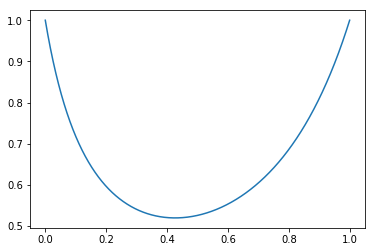

In [0]:
import matplotlib.pyplot as plt
num = 100000
ss = np.linspace(0, 1, num)
cbs = np.zeros((num))
for i in range(len(ss)):
  cd = distance(ss[i], m_mu, r_mu, m_co, r_co)
  cbs[i] = np.exp(-cd)
plt.plot(ss, cbs)

In [0]:
s = ss[np.where(cbs == cbs.min())]
cd = distance(s, m_mu, r_mu, m_co, r_co)
cb = math.pow(pr_m, s) * math.pow(pr_r, 1-s) * np.exp(-cd)
print('s=', s[0])
print('Chernoff error bound', cb[0])

s= 0.4264942649426494
Chernoff error bound 0.2566989422228011


## 參考資料
* [Pattern Recognition課堂講義](https://drphototw.wixsite.com/wujl/teaching)
